# Feature Selection
Feature selection for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the **early readmission of the patient within 30 days of discharge**.

The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals (as the patients are readmitted) but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [307]:
# Data Analysis
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [308]:
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from xgboost import XGBClassifier

### 0.2 Constants

In [309]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

RANDOM_STATE = 38

### 0.3 Loading datasets

In [310]:
diabetic_data = pd.read_csv(
    DATA_PATH_PROCESSED + 'diabetic_data_cleaned.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Training & Test Split**
Splitting the dataset into training and test sets.

In [311]:
diabetic_data['readmitted'].value_counts(normalize=True) * 100

readmitted
0    90.997624
1     9.002376
Name: proportion, dtype: float64

It's pretty easy to see that there is a strong imbalance between the two classes we want to predict:

- **Late or non-readmission:** ~91%
- **Early-readmission:** ~9%

For this reason, we need to balance the training dataset to ensure that both classes will be predicted properly. Since we can already assume that the training set will drastically reduce in size, we apply a 70-30 split (70% training and 30% test).

In [312]:
# Remove discharge_home since it's highly correlated with discharge_transfer
diabetic_data.drop(columns=['discharge_home'], inplace=True)

In [313]:
# Split in training and test sets
X = diabetic_data.drop(columns='readmitted')
y = diabetic_data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    diabetic_data.drop(columns='readmitted'),
    y,
    test_size=0.3, # 0.3 is good
    stratify=y,
    random_state=RANDOM_STATE
)

In [314]:
# Add the 'readmitted' column back to the training and test sets
train_data_scaled = X_train.copy()
train_data_scaled['readmitted'] = y_train

test_data_scaled = X_test.copy()
test_data_scaled['readmitted'] = y_test

In [315]:
diabetic_data['readmitted'].value_counts()

readmitted
0    65501
1     6480
Name: count, dtype: int64

In [316]:
train_data_scaled['readmitted'].value_counts()

readmitted
0    45850
1     4536
Name: count, dtype: int64

In [317]:
test_data_scaled['readmitted'].value_counts()

readmitted
0    19651
1     1944
Name: count, dtype: int64

## **2. Undersampling & Oversampling**
Taking care of dataset class imbalance.

We don't want the final training set too small, so we don't want to undersample the majority class too much. But we also don't want to excessively oversample the minority class, since that would cause overfitting for the predictions of the minority class.

We decided to increase by up to an half the number of minority instances, by generating them with SMOTE (Synthetic Minority Over-sampling Technique) to get similar instances (but not duplicates of the original), and to randomly sample the majority instances to a number slightly higher than the minority instances.

In the end, we end up with a test set that is actually bigger than the training set, but in cases like this with strong class imbalance it's perfectly normal.

In [318]:
# Undersample the majority class
undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=RANDOM_STATE) # 0.7 is good
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Oversample minority class
smote = SMOTE(sampling_strategy=0.8, random_state=RANDOM_STATE) # 0.9 or 1.0 is good
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape with RandomUnderSampler', Counter(y_train_resampled))

Original dataset shape Counter({0: 45850, 1: 4536})
Resample dataset shape with RandomUnderSampler Counter({0: 6480, 1: 5184})


## **3. Feature Scaling**
Applying scaling to features before running models for feature selection.

In [319]:
NUMERICAL_COLUMNS = [
    'age',
    'num_inpatient', 'num_outpatient', 'num_emergency',
    'num_medications', 'num_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital'
]

In [320]:
# Initialize the StandardScaler
scaler_std = StandardScaler()

X_train_resampled[NUMERICAL_COLUMNS] = scaler_std.fit_transform(X_train_resampled[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler_std.transform(X_test[NUMERICAL_COLUMNS])

## **4. Feature Selection**
Selecting the best $K$ features from the dataset.

In [321]:
# Number of features to select
K = 10 # 10 is good, 7 slightly less good

### 4.1 Random Forest

In [322]:
rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=20,
    max_depth=10,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=20, random_state=38)

In [323]:
y_train_pred = rf.predict(X_train_resampled)
y_test_pred = rf.predict(X_test)

In [324]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.6660665294924554
Test accuracy:  0.6369066913637416


In [325]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.65      0.76     19651
           1       0.13      0.53      0.21      1944

    accuracy                           0.64     21595
   macro avg       0.53      0.59      0.49     21595
weighted avg       0.86      0.64      0.71     21595



<Axes: >

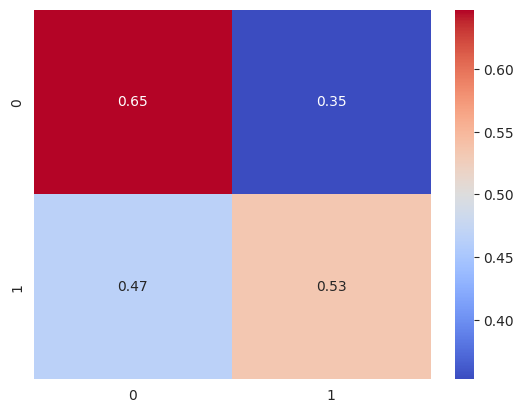

In [326]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm')

In [327]:
# Select the K=10 best features with highest lasso coefficients
features = pd.DataFrame({'feature': X_train_resampled.columns, 'importance': rf.feature_importances_})
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features = features.head(K)
features = features['feature'].values
features_rf = features

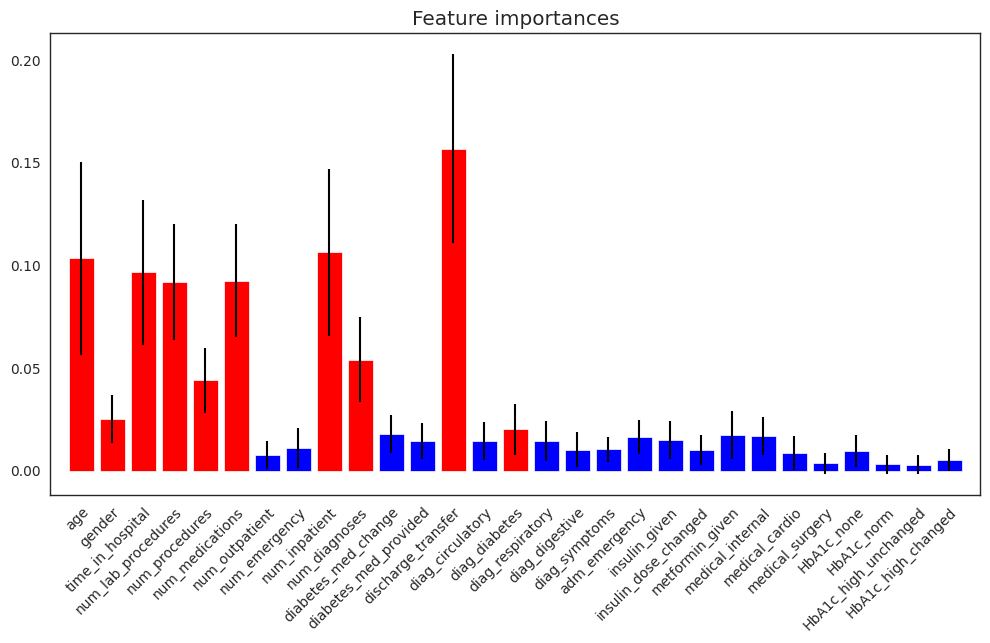

In [328]:
importances_rf = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

# Plot the feature importances of the forest
colors = ['r' if c in features else 'b' for c in X_train_resampled.columns]

plt.figure(1, figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train_resampled.shape[1]), importances_rf,
       color=colors, yerr=std, align="center")
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns, rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train_resampled.shape[1]])
plt.show()

##### 4.1.1 Testing features

In [329]:
rf = RandomForestClassifier(
    n_estimators=100,
    # min_samples_leaf=20,
    max_depth=12,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train_resampled[features], y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=38)

In [330]:
y_train_pred = rf.predict(X_train_resampled[features])
y_test_pred = rf.predict(X_test[features])

In [331]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.8149862825788752
Test accuracy:  0.6728409354017134


In [332]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     19651
           1       0.13      0.47      0.21      1944

    accuracy                           0.67     21595
   macro avg       0.53      0.58      0.50     21595
weighted avg       0.86      0.67      0.74     21595



<Axes: >

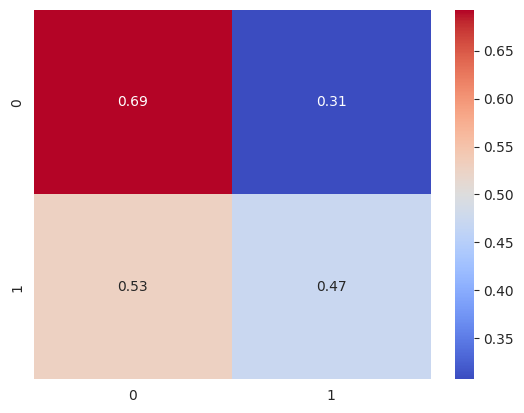

In [333]:
cm_rf = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_rf, annot=True, fmt=".2f", cmap='coolwarm')

### 4.2 XGBoost

In [334]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train_resampled) - sum(y_train_resampled)) / sum(y_train_resampled), # Ratio negative/positive
    random_state=RANDOM_STATE
)
xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=38, ...)

In [335]:
y_train_pred = xgb.predict(X_train_resampled)
y_test_pred = xgb.predict(X_test)

In [336]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.9401577503429356
Test accuracy:  0.6514470942347765


In [337]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78     19651
           1       0.12      0.47      0.20      1944

    accuracy                           0.65     21595
   macro avg       0.53      0.57      0.49     21595
weighted avg       0.86      0.65      0.73     21595



<Axes: >

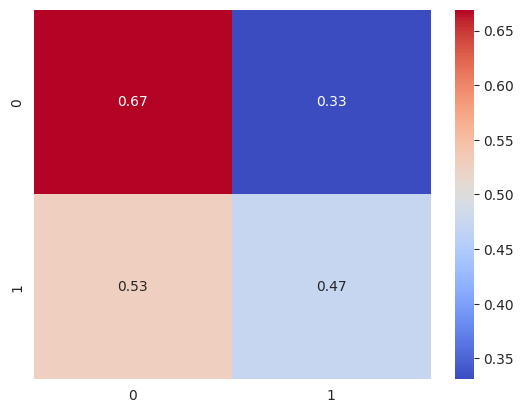

In [338]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm')

In [339]:
# Select the K=10 best features with highest lasso coefficients
features = pd.DataFrame({'feature': X_train_resampled.columns, 'importance': xgb.feature_importances_})
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features = features.head(K)
features = features['feature'].values
features_xgb = features

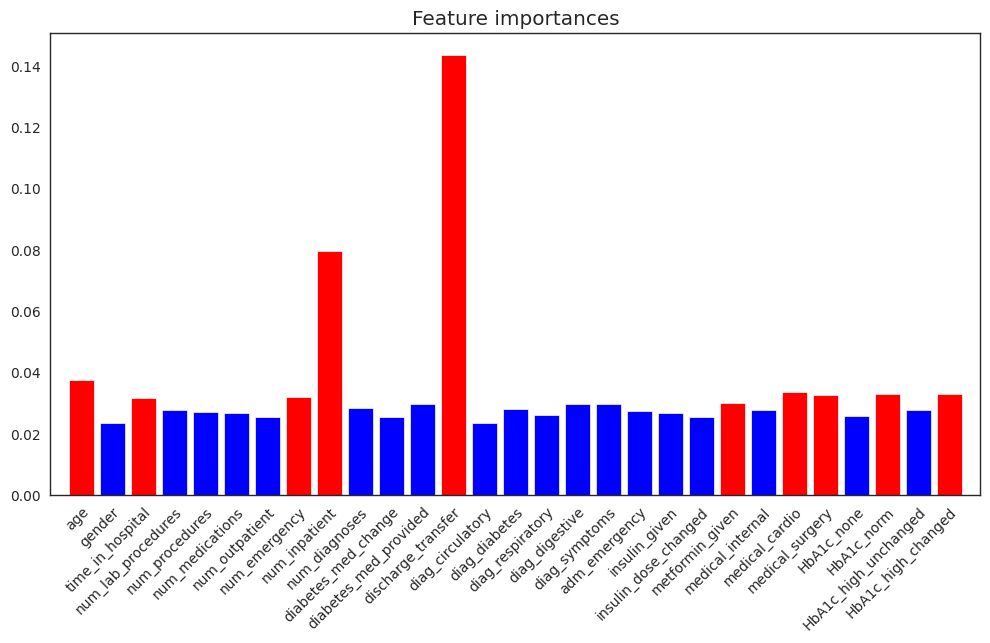

In [340]:
importances_xgb = xgb.feature_importances_
# std = np.std([tree.feature_importances_ for tree in xgb.estimators_],
#              axis=0)

# Plot the feature importances of the forest
colors = ['r' if c in features else 'b' for c in X_train_resampled.columns]

plt.figure(1, figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train_resampled.shape[1]), importances_xgb,
       color=colors, align="center")
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns,  rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train_resampled.shape[1]])
plt.show()

##### 4.2.1 Testing features

In [341]:
rf = RandomForestClassifier(
    n_estimators=100,
    # min_samples_leaf=20,
    max_depth=12,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train_resampled[features], y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=38)

In [342]:
y_train_pred = rf.predict(X_train_resampled[features])
y_test_pred = rf.predict(X_test[features])

In [343]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.6984739368998628
Test accuracy:  0.6647372076869645


In [344]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.68      0.79     19651
           1       0.13      0.48      0.20      1944

    accuracy                           0.66     21595
   macro avg       0.53      0.58      0.50     21595
weighted avg       0.86      0.66      0.74     21595



<Axes: >

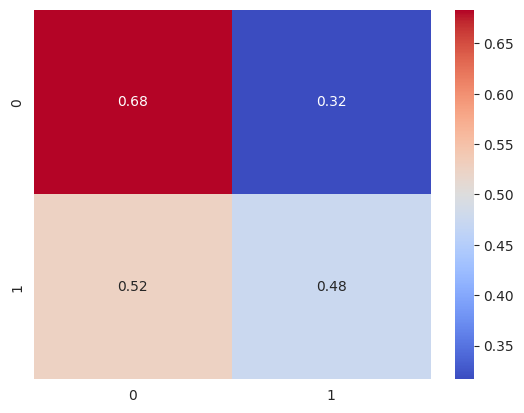

In [345]:
cm_xgb = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_xgb, annot=True, fmt=".2f", cmap='coolwarm')

### 4.3 K-best

In [346]:
def get_feature_univ_scores(univ_fselector, columns):
    return pd.DataFrame(
        data=[univ_fselector.scores_, univ_fselector.pvalues_],
        index=["score", "pvalue"],
        columns=columns,
    ).T

In [347]:
kbest = SelectKBest(k=K)
kbest.fit(X_train_resampled, y_train_resampled)

SelectKBest()

In [348]:
features = X_train_resampled.columns[kbest.get_support()]
features_kbest = features

In [349]:
scores_pvalue = get_feature_univ_scores(kbest, X_train.columns)
importances_kbest = scores_pvalue['score']

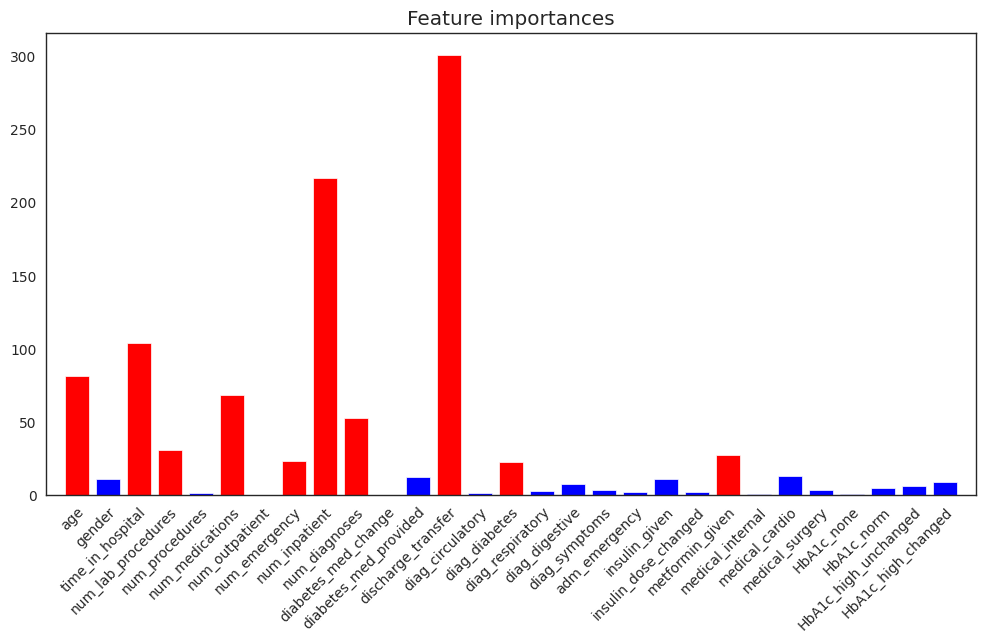

In [350]:
colors = ['r' if c in features else 'b' for c in X_train_resampled.columns]

plt.figure(1, figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train_resampled.shape[1]), scores_pvalue['score'],
       color=colors, align="center")
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns, rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train_resampled.shape[1]])
plt.show()

##### 4.3.1 Testing features

In [351]:
rf = RandomForestClassifier(
    n_estimators=100,
    # min_samples_leaf=20,
    max_depth=12,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train_resampled[features], y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=38)

In [352]:
y_train_pred = rf.predict(X_train_resampled[features])
y_test_pred = rf.predict(X_test[features])

In [353]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.7888374485596708
Test accuracy:  0.6756656633479973


In [354]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.69      0.80     19651
           1       0.14      0.48      0.21      1944

    accuracy                           0.68     21595
   macro avg       0.53      0.59      0.50     21595
weighted avg       0.86      0.68      0.74     21595



<Axes: >

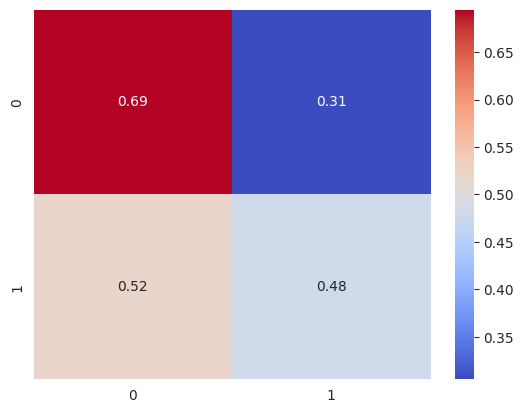

In [355]:
cm_kbest = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_kbest, annot=True, fmt=".2f", cmap='coolwarm')

### 4.4 RFE

In [356]:
def get_feature_rfe_ranking(
    mb_fselector, columns,
):
    return pd.DataFrame(
        data=[mb_fselector.ranking_], index=["ranking"], columns=columns,
    ).T

In [357]:
clf_rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=20,
    max_depth=10,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

rfe = RFE(
    estimator=clf_rf,
    n_features_to_select=K,
    step=1
)
rfe.fit(X_train_resampled, y_train_resampled)

RFE(estimator=RandomForestClassifier(class_weight='balanced', max_depth=10,
                                     min_samples_leaf=20, random_state=38),
    n_features_to_select=10)

In [358]:
print('Chosen best 10 feature by rfe:', X_train_resampled.columns[rfe.support_])

Chosen best 10 feature by rfe: Index(['age', 'gender', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'num_inpatient', 'num_diagnoses',
       'discharge_transfer', 'diag_diabetes'],
      dtype='object')


In [359]:
features = X_train_resampled.columns[rfe.support_]
features_rfe = features

In [360]:
feature_rfe = get_feature_rfe_ranking(rfe, X_train_resampled.columns)
importances_rfe = feature_rfe['ranking']

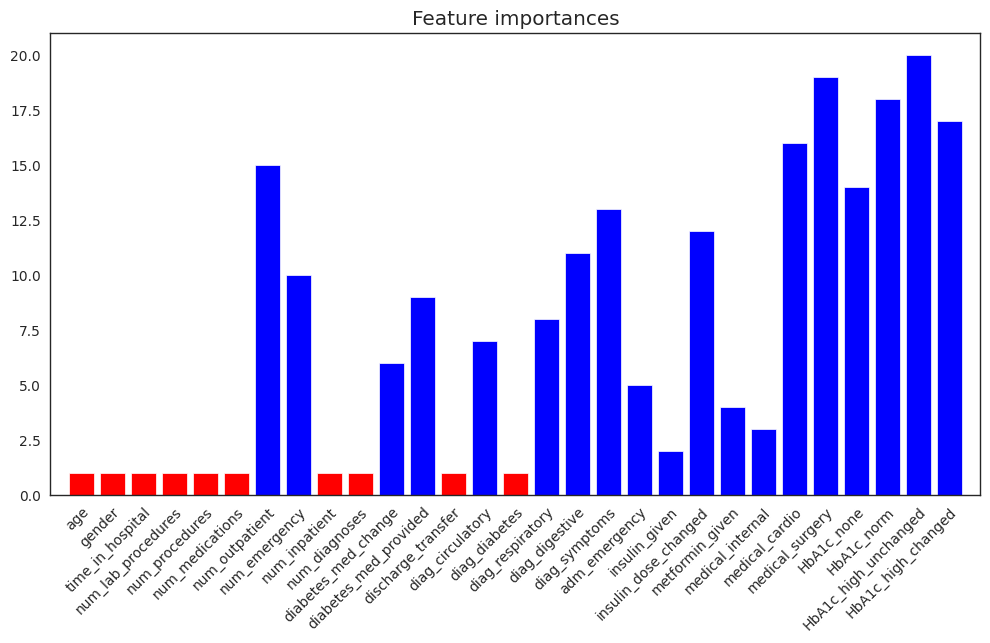

In [361]:
colors = ['r' if c in features else 'b' for c in X_train_resampled.columns]

plt.figure(1, figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train_resampled.shape[1]), feature_rfe['ranking'],
       color=colors, align="center")
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns, rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train_resampled.shape[1]])
plt.show()

##### 4.4.1 Testing features

In [362]:
rf = RandomForestClassifier(
    n_estimators=100,
    # min_samples_leaf=20,
    max_depth=12,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train_resampled[features], y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=38)

In [363]:
y_train_pred = rf.predict(X_train_resampled[features])
y_test_pred = rf.predict(X_test[features])

In [364]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.8148148148148148
Test accuracy:  0.673257698541329


In [365]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     19651
           1       0.13      0.47      0.21      1944

    accuracy                           0.67     21595
   macro avg       0.53      0.58      0.50     21595
weighted avg       0.86      0.67      0.74     21595



<Axes: >

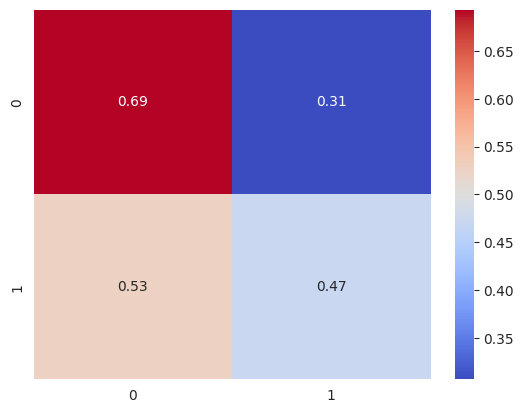

In [366]:
cm_rfe = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_rfe, annot=True, fmt=".2f", cmap='coolwarm')

### 4.5 Results Combined

#### 4.5.1 Confusion Matrices Combined

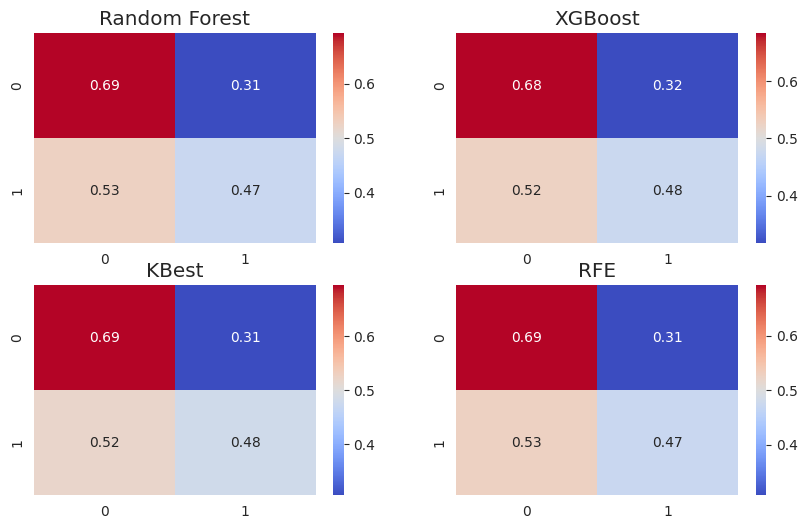

In [367]:
# Combine all confusion matrices into one single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
cm_list = [cm_rf, cm_xgb, cm_kbest, cm_rfe]
titles = ['Random Forest', 'XGBoost', 'KBest', 'RFE']

for i, cm in enumerate(cm_list):
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm', ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(titles[i])
    
plt.show()

#### 4.5.2 Feature Importances Combined

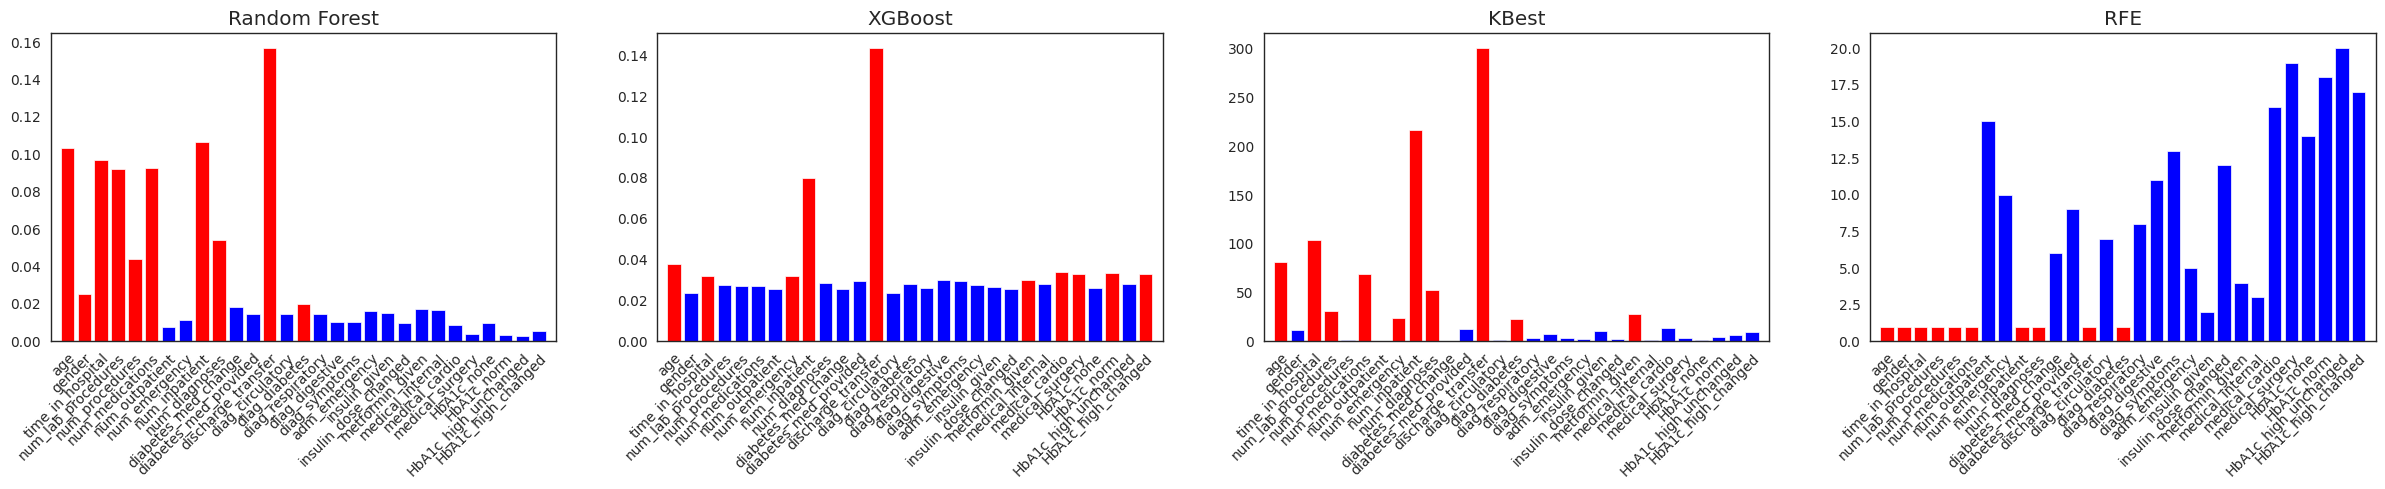

In [368]:
# Combine all feature importances plots into one single plot
fig, axs = plt.subplots(1, 4, figsize=(30, 4))
features_list = [features_rf, features_xgb, features_kbest, features_rfe]
importances_list = [importances_rf, importances_xgb, importances_kbest, importances_rfe]
titles = ['Random Forest', 'XGBoost', 'KBest', 'RFE']

# Plot without labels being covered by other plots
for i, (features, importances) in enumerate(zip(features_list, importances_list)):
    colors = ['r' if c in features else 'b' for c in X_train_resampled.columns]
    axs[i%4].bar(range(X_train_resampled.shape[1]), importances,
           color=colors, align="center")
    axs[i%4].set_title(titles[i])
    axs[i%4].set_xticks(range(X_train_resampled.shape[1]))
    axs[i%4].set_xticklabels(X_train_resampled.columns, rotation=45, ha='right', rotation_mode='anchor')
    axs[i%4].set_xlim([-1, X_train_resampled.shape[1]])
    
plt.show()

We select the $K$ features that appear most frequently across all selectors.

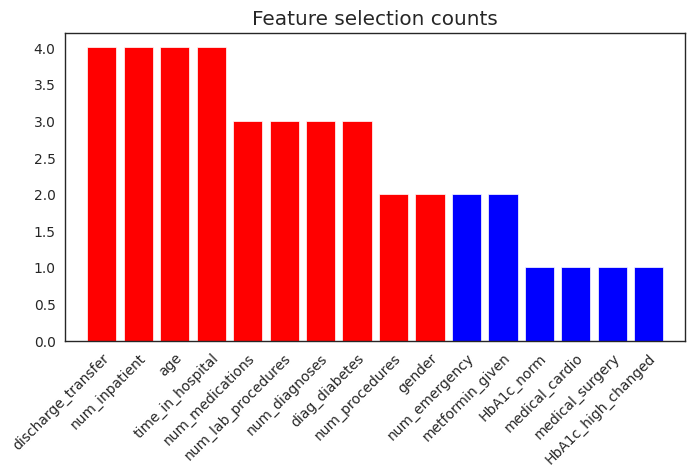

In [369]:
# Count the number of times each feature was selected
features = np.concatenate(features_list)
features = pd.Series(features)
features_counts = features.value_counts()

# Color the first K features selected by each method in red
colors = ['r' if c in features_counts.index[:K] else 'b' for c in features_counts.index]

# Plot the number of times each feature was selected
plt.figure(1, figsize=(8, 4))
plt.title("Feature selection counts")
plt.bar(range(len(features_counts)), features_counts,
       color=colors, align="center")
plt.xticks(range(len(features_counts)), features_counts.index, rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, len(features_counts)])
plt.show()

## **5. Final Dataset**
Filtering the dataset with the selected features, generating training and test sets, and saving them.

### 5.1 Original dataset feature filtering

In [370]:
selected_features = features_counts.index[:K]
final_diabetic_data = diabetic_data[list(selected_features) + ['readmitted']]
final_diabetic_data.reset_index(drop=True, inplace=True)
final_diabetic_data

,discharge_transfer,num_inpatient,age,time_in_hospital,num_medications,num_lab_procedures,num_diagnoses,diag_diabetes,num_procedures,gender,readmitted
0,0,0,5.0,8.0,33,77,8,0,6,1,1
1,0,0,5.0,2.0,11,49,3,1,1,1,0
2,1,0,8.0,4.0,23,68,9,0,2,1,0
3,0,0,8.0,3.0,20,46,9,0,0,1,0
4,0,0,3.0,5.0,5,49,3,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
71976,0,0,8.0,1.0,11,73,9,0,1,1,0
71977,0,0,6.0,3.0,8,56,7,1,1,0,0
71978,0,0,8.0,3.0,18,39,9,0,0,1,0
71979,1,0,4.0,13.0,16,69,5,1,0,1,0


### 5.2 Duplicates check

In [371]:
duplicated = final_diabetic_data[diabetic_data.duplicated()]
duplicated

,discharge_transfer,num_inpatient,age,time_in_hospital,num_medications,num_lab_procedures,num_diagnoses,diag_diabetes,num_procedures,gender,readmitted


In [372]:
if not duplicated.empty:
    final_diabetic_data.drop_duplicates(inplace=True)
    final_diabetic_data.reset_index(drop=True, inplace=True)

### 5.3 Training & test split

In [373]:
# Split in training and test sets
X = final_diabetic_data.drop(columns='readmitted')
y = final_diabetic_data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    final_diabetic_data.drop(columns='readmitted'),
    y,
    test_size=0.3, # 0.3 is good
    stratify=y,
    random_state=RANDOM_STATE
)

In [374]:
# Add the 'readmitted' column back to the training and test sets
train_data_scaled = X_train.copy()
train_data_scaled['readmitted'] = y_train

test_data_scaled = X_test.copy()
test_data_scaled['readmitted'] = y_test

In [375]:
final_diabetic_data['readmitted'].value_counts()

readmitted
0    65501
1     6480
Name: count, dtype: int64

In [376]:
train_data_scaled['readmitted'].value_counts()

readmitted
0    45850
1     4536
Name: count, dtype: int64

In [377]:
test_data_scaled['readmitted'].value_counts()

readmitted
0    19651
1     1944
Name: count, dtype: int64

### 5.4 Undersampling & oversampling

We are increasing a little bit the size of the training set compared to before, to account for a validation set.

In [378]:
# Undersample the majority class
undersampler = RandomUnderSampler(sampling_strategy=0.64, random_state=RANDOM_STATE) # 0.7 is good
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Oversample minority class
smote = SMOTE(sampling_strategy=0.8, random_state=RANDOM_STATE) # 0.9 or 1.0 is good
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape with RandomUnderSampler', Counter(y_train_resampled))

Original dataset shape Counter({0: 45850, 1: 4536})
Resample dataset shape with RandomUnderSampler Counter({0: 7087, 1: 5669})


### 5.5 Saving to CSV

In [379]:
train_set = pd.concat([X_train_resampled, y_train_resampled], axis=1)
train_set.to_csv(DATA_PATH_PROCESSED + 'train.csv', index=False)

In [380]:
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv(DATA_PATH_PROCESSED + 'test.csv', index=False)